In [1]:
import autograd as Agrad
import autograd.numpy as np 
import scipy.optimize
# -- plotting --- 
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [59]:
xpix = np.linspace(0., 1., 200) # pixel gridding 
sig_psf = 0.02 # psf width
sig_noise = 0.2 # noise level 

In [60]:
def psi(xpos): 
    ''' measurement model, which in our case is just a 1d gaussian of width 
    sigma (PSF) written out to xpix 
    '''
    return np.exp(-((xpix - xpos)/sig_psf)**2)

In [61]:
theta_grid = np.linspace(0., 1., len(xpix)) # gridding of theta (same as pixels)
grid_psi = np.stack([psi(tt) for tt in theta_grid])

In [62]:
def Psi(ws, xs): 
    ''' "forward operator" i.e. forward model 
    
    Psi = int psi(theta) dmu(theta) 

    where mu is the signal parameter
    '''
    return np.sum(np.array([w * psi(tt) for (w,tt) in zip(ws, xs)]),0)

In [63]:
np.random.seed(1)
Ndata = 5
x_true = np.random.rand(Ndata) # location of sources
w_true = np.random.rand(Ndata)*2 # with intensity betwen 1-2
w_true_grid = np.zeros(len(theta_grid))
for x, w in zip(x_true, w_true): 
    w_true_grid[np.argmin(np.abs(theta_grid - x))] = w
data = Psi(w_true, x_true) + sig_noise * np.random.randn(len(xpix))
fdensity = float(Ndata)/float(len(xpix))

(0.0, 2.5)

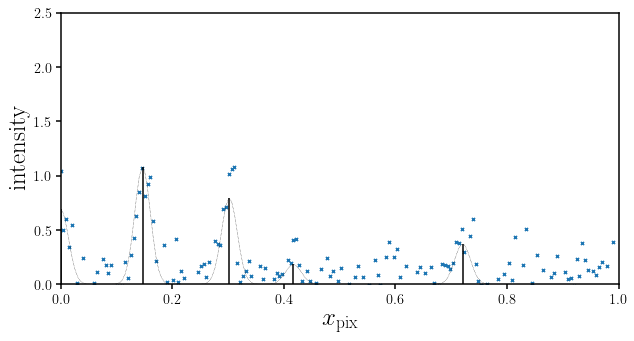

In [64]:
# plot data 
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(xpix, data, marker='x', s=10) 
for i in range(len(x_true)):
    sub.plot(xpix, w_true[i] * psi(x_true[i]), c='k', ls=':', lw=0.5)
for x, w in zip(x_true, w_true): 
    sub.vlines(x, 0, w, color='k')
sub.set_xlabel(r'$x_{\rm pix}$', fontsize=25) 
sub.set_xlim(0., 1.) 
sub.set_ylabel('intensity', fontsize=25) 
sub.set_ylim(0., 2.5) 


In [65]:
def lnlike(ws): 
    ''' log likelihood 
    '''
    return -0.5 * np.sum((Psi(ws, theta_grid) - data)**2/sig_noise**2) 

(0.0, 2.5)

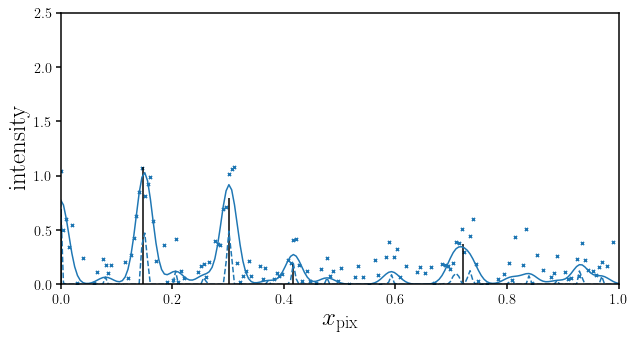

In [66]:
tt0 = np.zeros(len(theta_grid))
res = scipy.optimize.minimize(
        Agrad.value_and_grad(lambda tt: -1.*lnlike(tt)),  
        tt0, # theta initial 
        jac=True, 
        method='L-BFGS-B', 
        bounds=[(1e-10, 1e1)]*len(tt0))
ws_inf = res['x']
post_inf = res['fun'] 

# plot data 
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(xpix, data, marker='x', s=10) 
for x, w in zip(x_true, w_true): 
    sub.vlines(x, 0, w, color='k')
sub.plot(theta_grid, ws_inf, c='C0', ls='--')
sub.plot(theta_grid, Psi(ws_inf, theta_grid), c='C0')
sub.set_xlabel(r'$x_{\rm pix}$', fontsize=25) 
sub.set_xlim(0., 1.) 
sub.set_ylabel('intensity', fontsize=25) 
sub.set_ylim(0., 2.5) 

In [81]:
def gaussian(x, loc=None, scale=None): 
    y = (x - loc)/scale
    return np.exp(-0.5*y**2)/np.sqrt(2.*np.pi)/scale

def prior_i(w): 
    ''' log of Poisson prior for an indivudial pixel
    '''
    pri = 0.
    if 0. < w <= 2.: 
        pri += fdensity
    if w > 0: 
        pri += (1.-fdensity) * gaussian(np.log(w), loc=-4., scale=0.75)/w
    return pri
    
def lnprior(ws): 
    return np.sum([np.log(prior_i(w)) for w in ws])

(0.0, 0.07500000000000001)

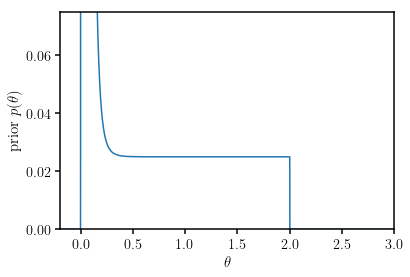

In [82]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(np.linspace(-1., 5., 10000), [prior_i(wi) for wi in np.linspace(-1., 5., 10000)])
sub.set_xlabel(r'$\theta$', fontsize=15)
sub.set_xlim(-0.2, 3.)
sub.set_ylabel(r'prior $p(\theta)$', fontsize=15)
sub.set_ylim(0., 3*fdensity)

In [83]:
def lnpost(ws): 
    return lnlike(ws) + lnprior(ws)

In [84]:
tt0 = np.ones(len(theta_grid))
res = scipy.optimize.minimize(
        Agrad.value_and_grad(lambda tt: -1.*lnpost(tt)),  
        tt0, # theta initial 
        jac=True, 
        method='L-BFGS-B', 
        bounds=[(1e-5, 1e1)]*len(tt0))
ws_inf = res['x']
post_inf = res['fun'] 

In [85]:
print ws_inf, post_inf, lnpost(np.clip(w_true_grid, 1e-5, None))

[1.67472129e-02 1.78673887e-02 1.69731535e-02 1.50024095e-02
 1.31983373e-02 1.18685247e-02 1.09690129e-02 1.03919080e-02
 1.00421961e-02 1.00000000e-05 1.00000000e-05 1.00000000e-05
 1.00000000e-05 1.00264544e-02 1.01851935e-02 1.03084760e-02
 1.03471577e-02 1.02810994e-02 1.01358580e-02 9.96973384e-03
 9.84271892e-03 9.79307809e-03 9.83108054e-03 9.94327191e-03
 1.01009485e-02 1.02701703e-02 1.04181844e-02 1.05196646e-02
 1.05589700e-02 1.05305536e-02 9.30970979e-01 1.02853369e-02
 1.00994787e-02 9.91339432e-03 9.76870869e-03 9.69960039e-03
 9.72295658e-03 9.83308633e-03 1.00039281e-02 1.01923724e-02
 1.03432102e-02 1.04022099e-02 1.03410410e-02 1.01792146e-02
 9.97868099e-03 9.81311301e-03 9.73801744e-03 9.77666589e-03
 9.91734221e-03 1.01171681e-02 1.03126840e-02 1.04440677e-02
 1.04823866e-02 1.04400527e-02 1.03565490e-02 1.02764623e-02
 1.02351526e-02 1.02514060e-02 1.03194478e-02 1.04017996e-02
 8.39875178e-01 1.03682857e-02 1.01959395e-02 9.97303681e-03
 9.76919933e-03 9.627098

(0.0, 2.5)

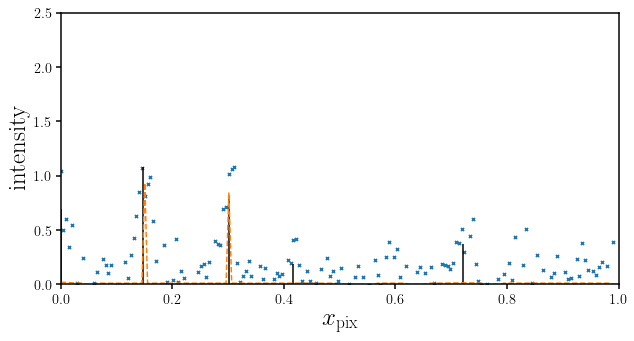

In [87]:
# plot data 
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(xpix, data, marker='x', s=10) 
for x, w in zip(x_true, w_true): 
    sub.vlines(x, 0, w, color='k')
sub.plot(theta_grid, ws_inf, c='C1', ls='--')
#sub.plot(theta_grid, Psi(ws_inf, theta_grid), c='C1')
sub.set_xlabel(r'$x_{\rm pix}$', fontsize=25) 
sub.set_xlim(0., 1.) 
sub.set_ylabel('intensity', fontsize=25) 
sub.set_ylim(0., 2.5) 